# Imports

In [102]:
import math
import datetime
import pandas as pd
import numpy as np
from statistics import median
from scipy.stats import iqr

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load data

In [2]:
data_path = '../../01_Data/'

In [3]:
items = pd.read_csv('{}items.csv'.format(data_path), sep='|')
items.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04


In [4]:
infos = pd.read_csv('{}infos.csv'.format(data_path), sep='|')
infos.head()

,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN


In [5]:
orders = pd.read_csv('{}orders_split/orders0206_train.csv'.format(data_path), sep='|')
orders.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [7]:
train = pd.merge(left=pd.merge(left=items, right=infos, on='itemID'), right=orders, on='itemID')

In [8]:
for cat_feature in 'brand manufacturer category1 category2 category3'.split():
    print('Number of unique {}s: {}'.format(cat_feature, train[cat_feature].nunique()))

Number of unique brands: 243
Number of unique manufacturers: 241
Number of unique category1s: 8
Number of unique category2s: 51
Number of unique category3s: 8


In [9]:
train['customerRating recommendedRetailPrice simulationPrice salesPrice'.split()].describe()

,customerRating,recommendedRetailPrice,simulationPrice,salesPrice
count,1.727364e+06,1.727364e+06,1.727364e+06,1.727364e+06
mean,2.412171e+00,3.260923e+01,3.453256e+01,3.792400e+01
std,2.268372e+00,9.975353e+01,1.310002e+02,1.323532e+02
min,0.000000e+00,2.460000e+00,3.800000e-01,0.000000e+00
25%,0.000000e+00,1.083000e+01,6.100000e+00,7.430000e+00
50%,3.000000e+00,1.629000e+01,1.481000e+01,1.745000e+01
75%,5.000000e+00,2.626000e+01,3.096000e+01,3.499000e+01
max,5.000000e+00,6.955000e+03,9.055070e+03,9.387020e+03


# Extract additional features on the time-dimension

In [10]:
train['time'] = train.apply(lambda row: datetime.datetime.strptime(row['time'],"%Y-%m-%d %H:%M:%S"), axis=1)

# Month of the year
train['month'] = train.apply(lambda row: row['time'].month, axis=1)

# Day of the month
train['day'] = train.apply(lambda row: row['time'].day, axis=1)

# Weekday: Starts with 0 = Monday, 6 = Sunday
train['weekday'] = train.apply(lambda row: row['time'].weekday(), axis=1)

# Just the date, no time
train['date'] = train.apply(lambda row: datetime.datetime(year=2018, month=row['month'], day=row['day']), axis=1)

# Hour of the day
train['hour'] = train.apply(lambda row: row['time'].hour, axis=1)

In [ ]:
# Calendar week
train['calendar_week'] = train.apply(lambda row: row['time'].isocalendar()[1], axis=1)

In [ ]:
train.to_csv('{}training_data0206.csv'.format(data_path), index=False, sep='|')

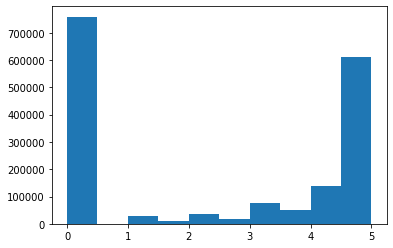

In [12]:
plt.hist(train['customerRating'])
plt.show()

# Exploration

In [13]:
def plot(x, y, agg):
    df_daily=train.groupby(x).agg([agg]).reset_index()
    if not isinstance(y, list):
        y = [y]
    for y_ in y:
            df_daily.plot(x=x, y=y_,kind="bar", title="{} of {} by {}".format(agg, y_, x))
    plt.show()

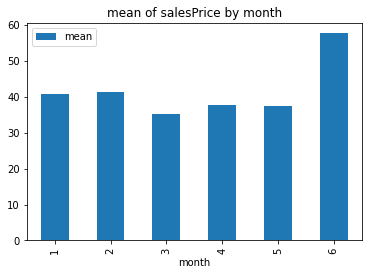

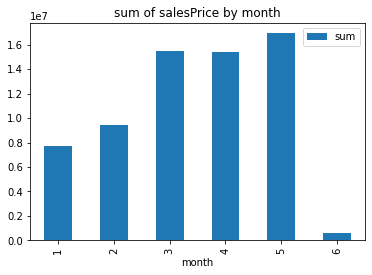

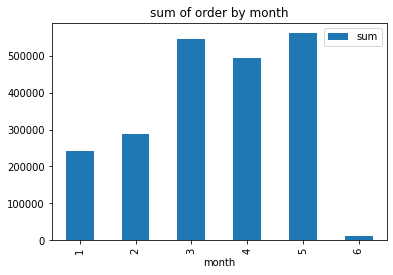

In [14]:
plot('month', ['salesPrice'], 'mean')
plot('month', ['salesPrice', 'order'], 'sum')

In [ ]:
plot('day', ['salesPrice'], 'mean')
plot('day', ['salesPrice', 'order'], 'sum')

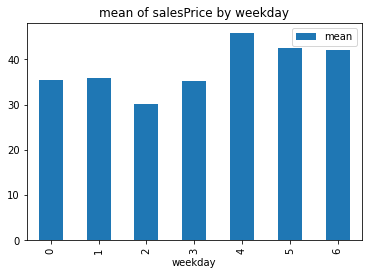

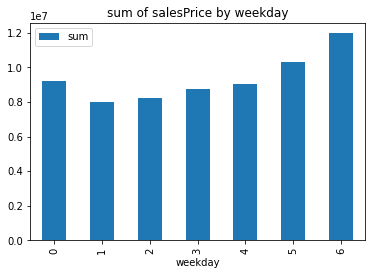

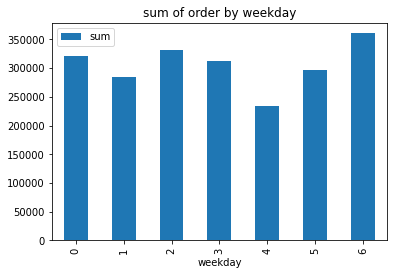

In [16]:
plot('weekday', ['salesPrice'], 'mean')
plot('weekday', ['salesPrice', 'order'], 'sum')

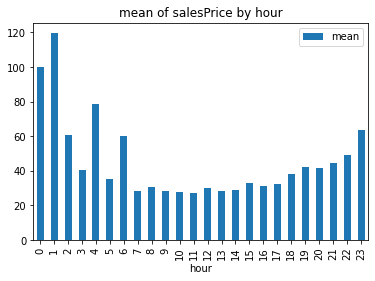

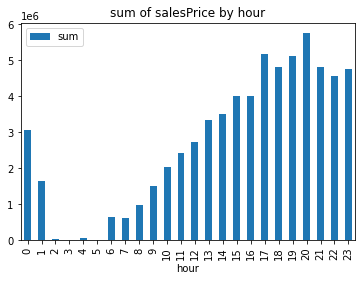

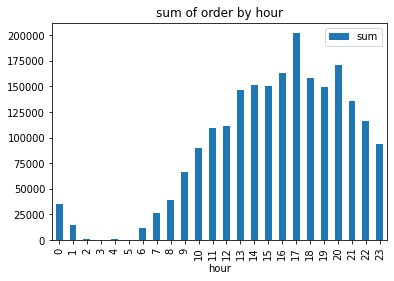

In [17]:
plot('hour', ['salesPrice'], 'mean')
plot('hour', ['salesPrice', 'order'], 'sum')

In [ ]:
plot('calendar_week', ['salesPrice'], 'mean')
plot('calendar_week', ['salesPrice', 'order'], 'sum')

# Feature generation: Price deviations

In [18]:
train['priceDifference'] = train['salesPrice'] - train['recommendedRetailPrice']

In [19]:
train['relPriceDifference'] = train['priceDifference'] / train['recommendedRetailPrice']

In [21]:
train.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,promotion,time,transactID,order,salesPrice,month,day,weekday,date,hour,priceDifference,relPriceDifference
0,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-23 16:46:03,2261889,1,3.11,1,23,1,2018-01-23,16,-5.73,-0.64819
1,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-25 13:32:34,2263523,1,3.11,1,25,3,2018-01-25,13,-5.73,-0.64819
2,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:00,162329,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819
3,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:01,162330,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819
4,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:01,162331,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819


# Feature generation: Identify promotions

In [22]:
def hasPromotion(row):
    if isinstance(row['promotion'], float):
        return False
    else:
        promotion_dates = row['promotion'].split(',')
        promotion_dates = [datetime.datetime.strptime(date,"%Y-%m-%d") for date in promotion_dates]
        if row['date'] in promotion_dates:
            return True
        else:
            False

In [23]:
train['hasPromotion'] = train.apply(lambda row: hasPromotion(row), axis=1)

In [24]:
train.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,promotion,time,transactID,order,salesPrice,month,day,weekday,date,hour,priceDifference,relPriceDifference,hasPromotion
0,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-23 16:46:03,2261889,1,3.11,1,23,1,2018-01-23,16,-5.73,-0.64819,False
1,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-25 13:32:34,2263523,1,3.11,1,25,3,2018-01-25,13,-5.73,-0.64819,False
2,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:00,162329,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819,False
3,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:01,162330,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819,False
4,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:01,162331,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819,False


In [32]:
list(train['promotion'].unique())

[nan,
 '2018-07-13',
 '2018-07-01,2018-07-02,2018-07-13',
 '2018-07-05,2018-07-11',
 '2018-07-01',
 '2018-07-04',
 '2018-07-08',
 '2018-07-05',
 '2018-07-09',
 '2018-06-30',
 '2018-07-11',
 '2018-07-06',
 '2018-07-08,2018-07-11',
 '2018-06-30,2018-07-13',
 '2018-06-30,2018-07-01,2018-07-11',
 '2018-07-08,2018-07-13',
 '2018-07-06,2018-07-13',
 '2018-07-06,2018-07-10',
 '2018-07-10',
 '2018-07-08,2018-07-10',
 '2018-06-30,2018-07-04',
 '2018-07-01,2018-07-10',
 '2018-07-02',
 '2018-06-30,2018-07-01',
 '2018-07-04,2018-07-05,2018-07-06',
 '2018-07-04,2018-07-05',
 '2018-07-03',
 '2018-07-03,2018-07-05',
 '2018-07-04,2018-07-09',
 '2018-07-04,2018-07-06',
 '2018-07-02,2018-07-04',
 '2018-07-12',
 '2018-07-03,2018-07-04',
 '2018-07-02,2018-07-03,2018-07-04',
 '2018-07-02,2018-07-03',
 '2018-07-01,2018-07-06',
 '2018-07-01,2018-07-08',
 '2018-07-02,2018-07-04,2018-07-06',
 '2018-07-02,2018-07-08',
 '2018-07-01,2018-07-04',
 '2018-07-02,2018-07-04,2018-07-08',
 '2018-07-02,2018-07-12',
 '201

##### Issue: All promotions indicated take place in the future, i.e. we need to find the promotions in our time period ourselves

In [31]:
train.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,promotion,time,transactID,order,salesPrice,month,day,weekday,date,hour,priceDifference,relPriceDifference
0,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-23 16:46:03,2261889,1,3.11,1,23,1,2018-01-23,16,-5.73,-0.64819
1,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-25 13:32:34,2263523,1,3.11,1,25,3,2018-01-25,13,-5.73,-0.64819
2,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:00,162329,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819
3,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:01,162330,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819
4,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:01,162331,1,3.11,1,29,0,2018-01-29,11,-5.73,-0.64819


In [38]:
df_daily = train.loc[train['itemID'] == 7761].groupby('date').agg(['sum']).reset_index()
df_daily.head()

,date,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,promotion,transactID,order,salesPrice,month,day,weekday,hour,priceDifference,relPriceDifference,hasPromotion
,,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
0,2018-01-01,7761,112,128,4.58,4,40,7,9.15,2.48,0,2293694,1,2.48,1,1,0,11,-6.67,-0.728962,False
1,2018-01-02,38805,560,640,22.90,20,200,35,45.75,12.40,0,9094671,10,12.40,5,10,5,78,-33.35,-3.644809,0
2,2018-01-03,15522,224,256,9.16,8,80,14,18.30,4.96,0,4563815,2,4.96,2,6,4,21,-13.34,-1.457923,0
3,2018-01-04,15522,224,256,9.16,8,80,14,18.30,4.96,0,4561510,2,4.96,2,8,6,29,-13.34,-1.457923,0
4,2018-01-06,15522,224,256,9.16,8,80,14,18.30,4.96,0,2293223,2,4.96,2,12,10,39,-13.34,-1.457923,0


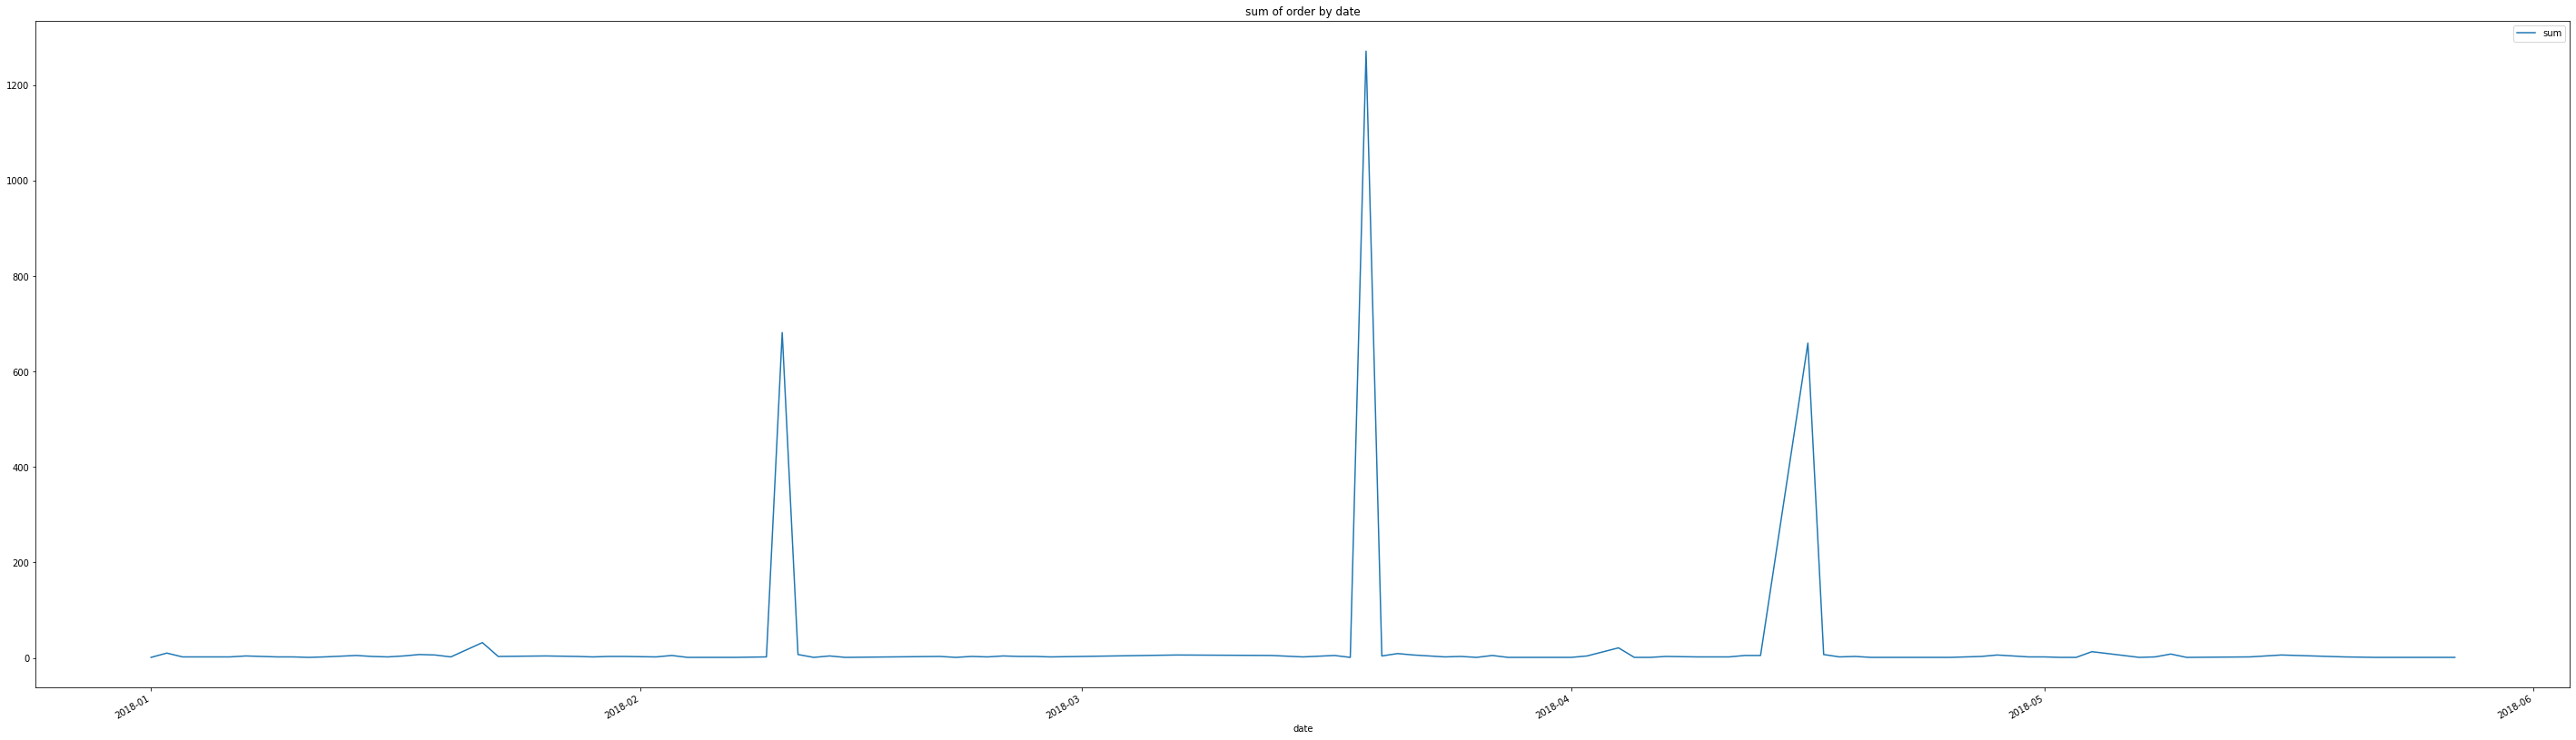

In [40]:
df_daily.plot(x='date', y='order',kind="line", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))

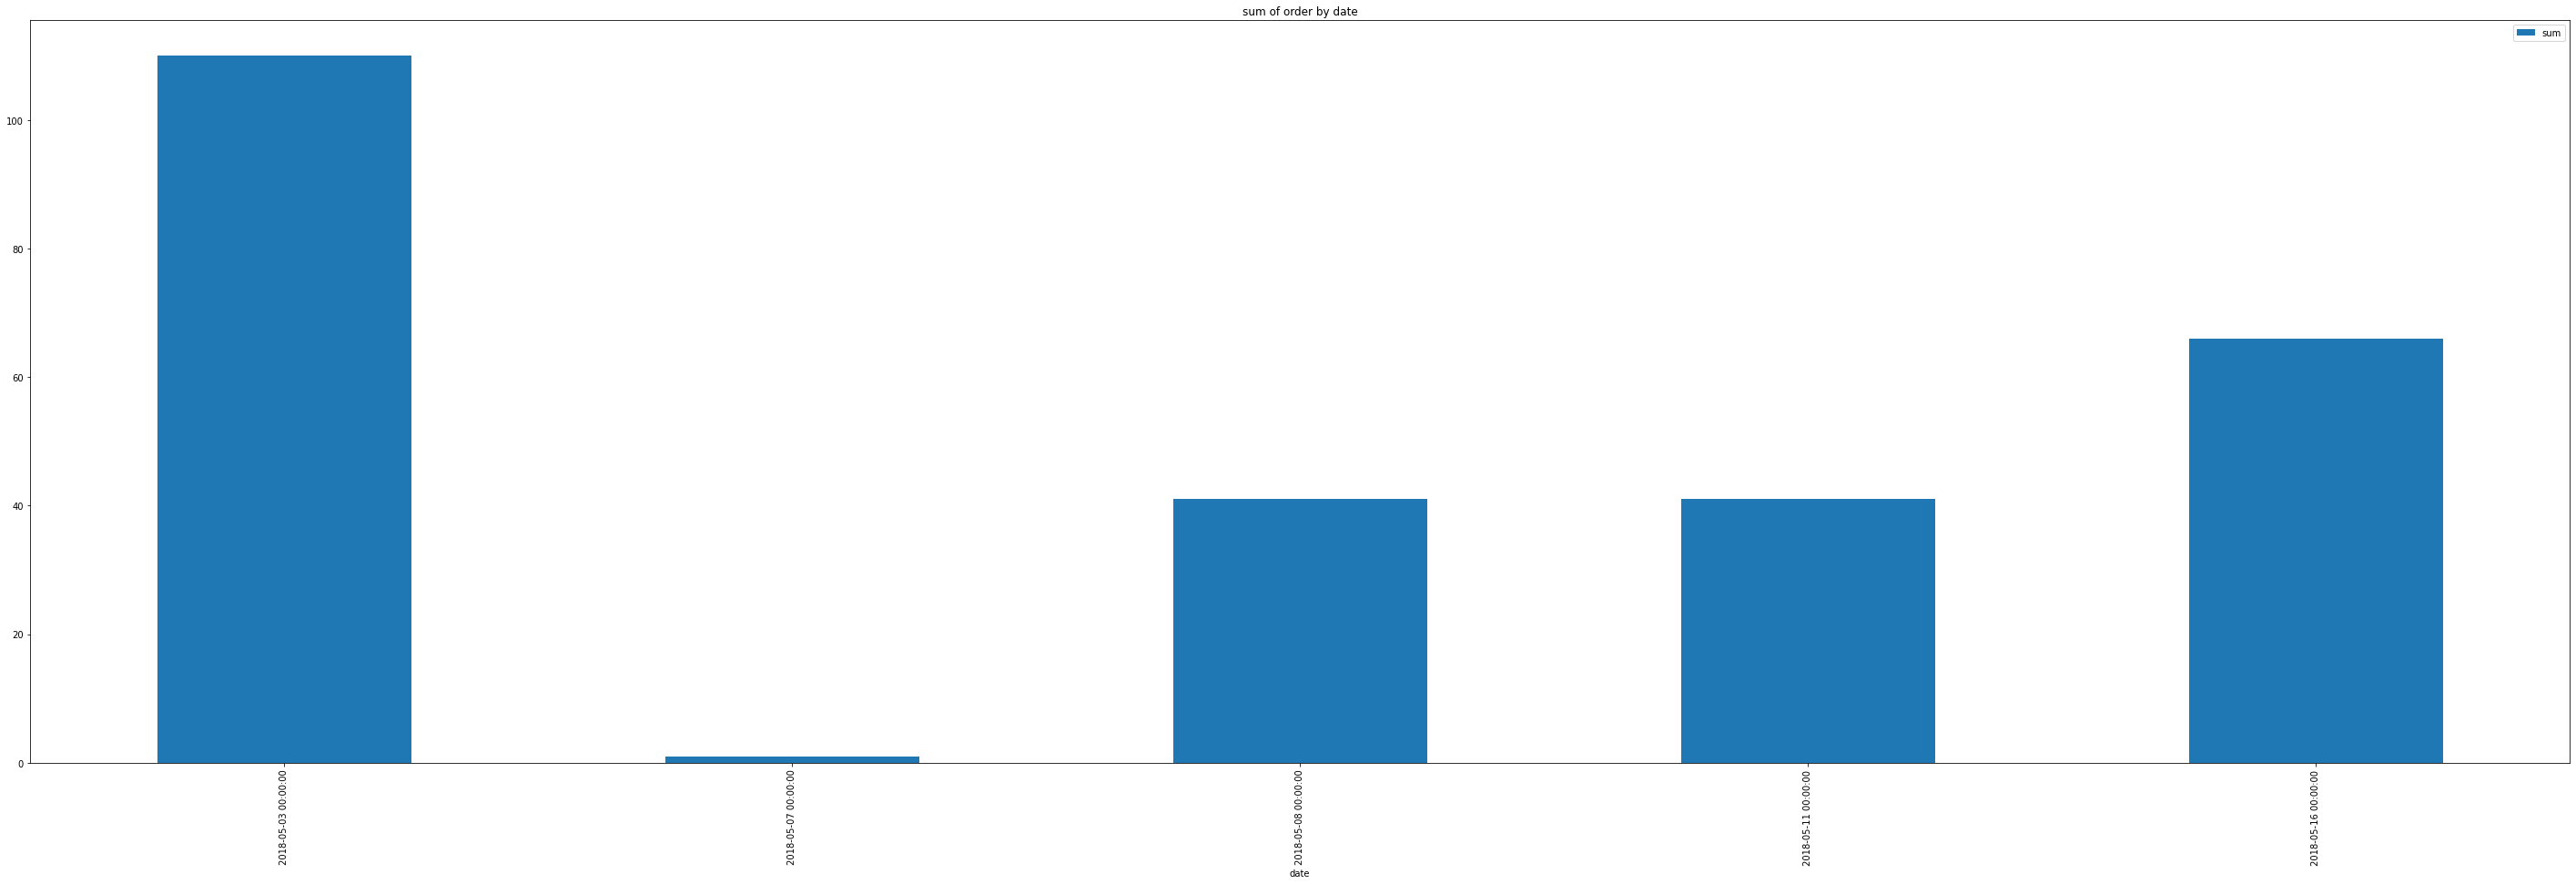

In [36]:
df_daily = train.loc[train['itemID'] == 1253].groupby('date').agg(['sum']).reset_index()
df_daily.plot(x='date', y='order',kind="bar", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))

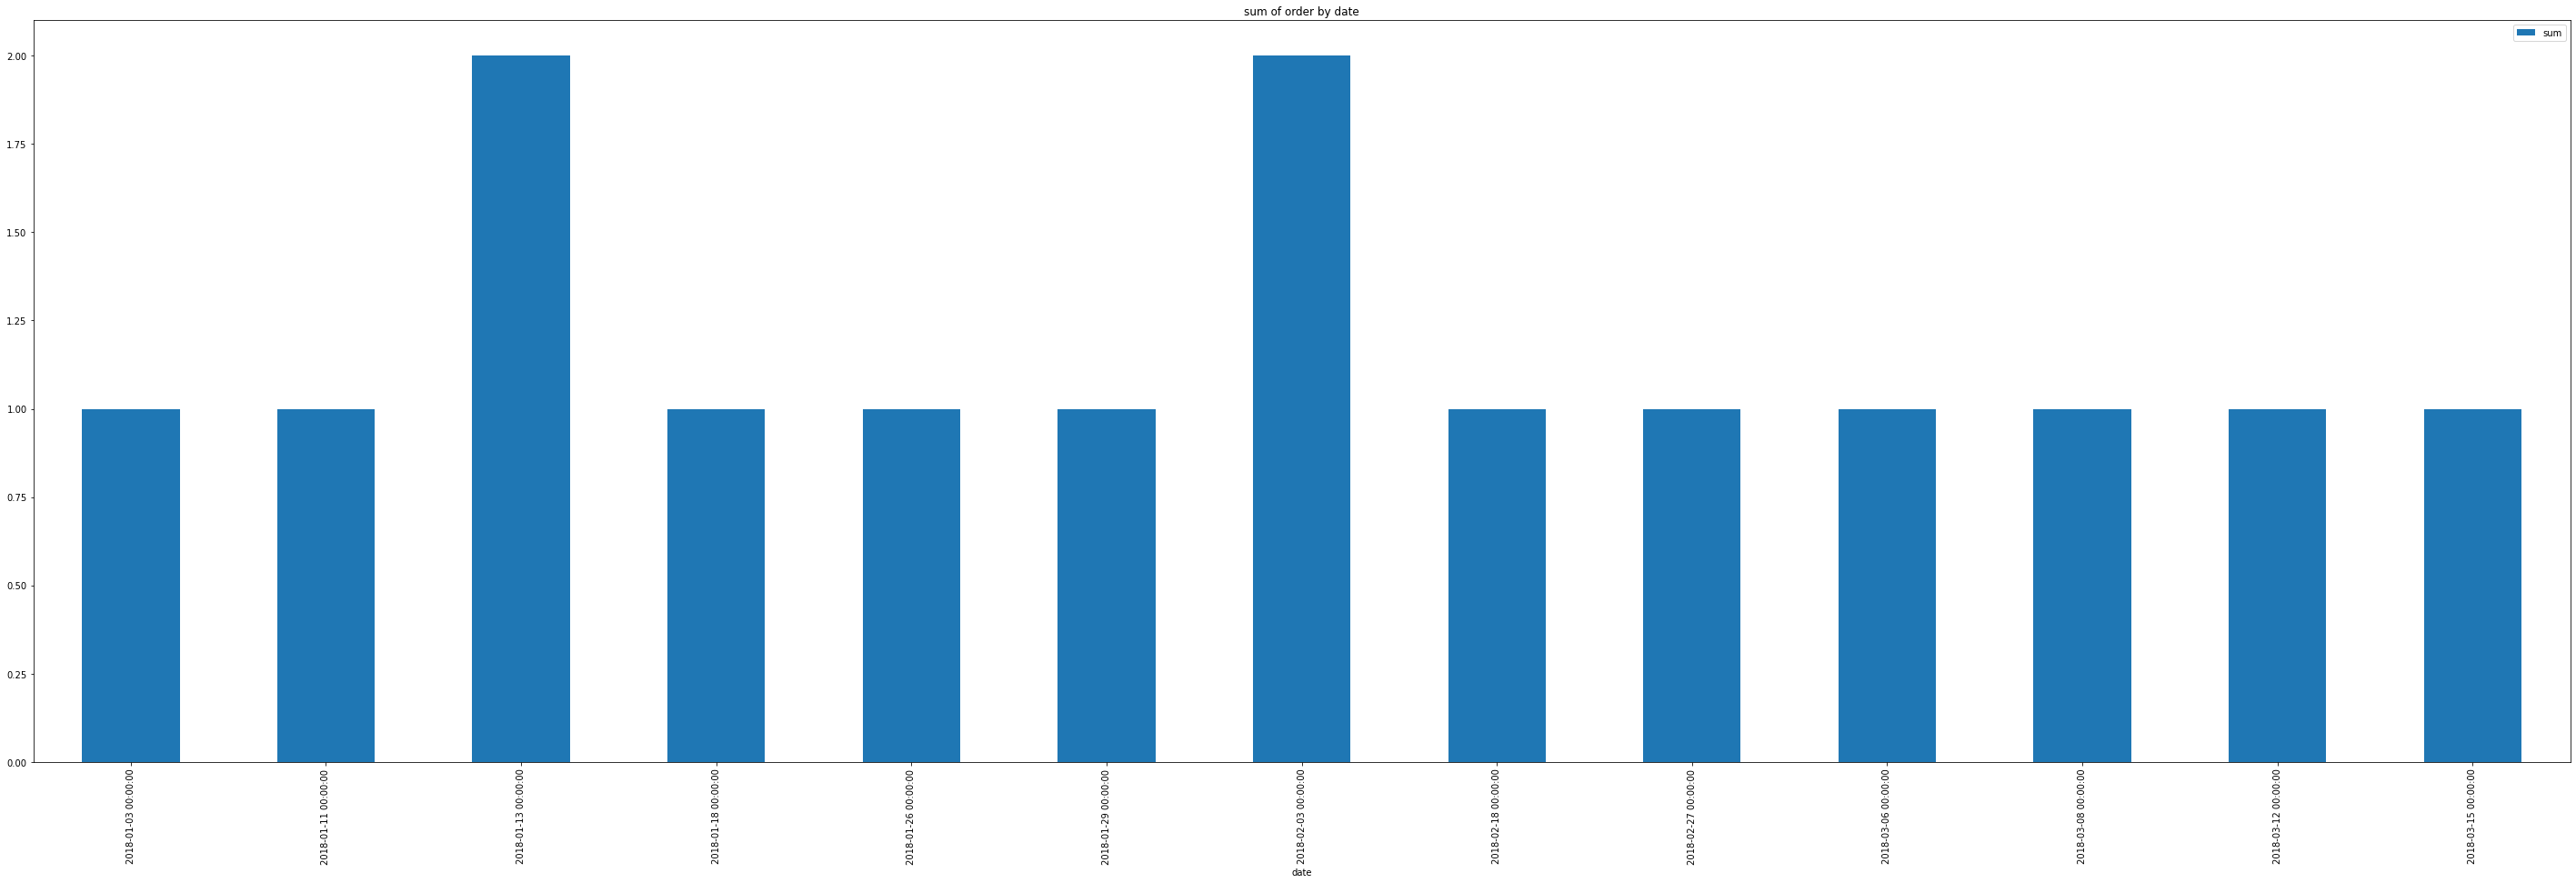

In [28]:
df_daily = train.loc[train['itemID'] == 24].groupby('date').agg(['sum']).reset_index()
df_daily.plot(x='date', y='order',kind="bar", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))

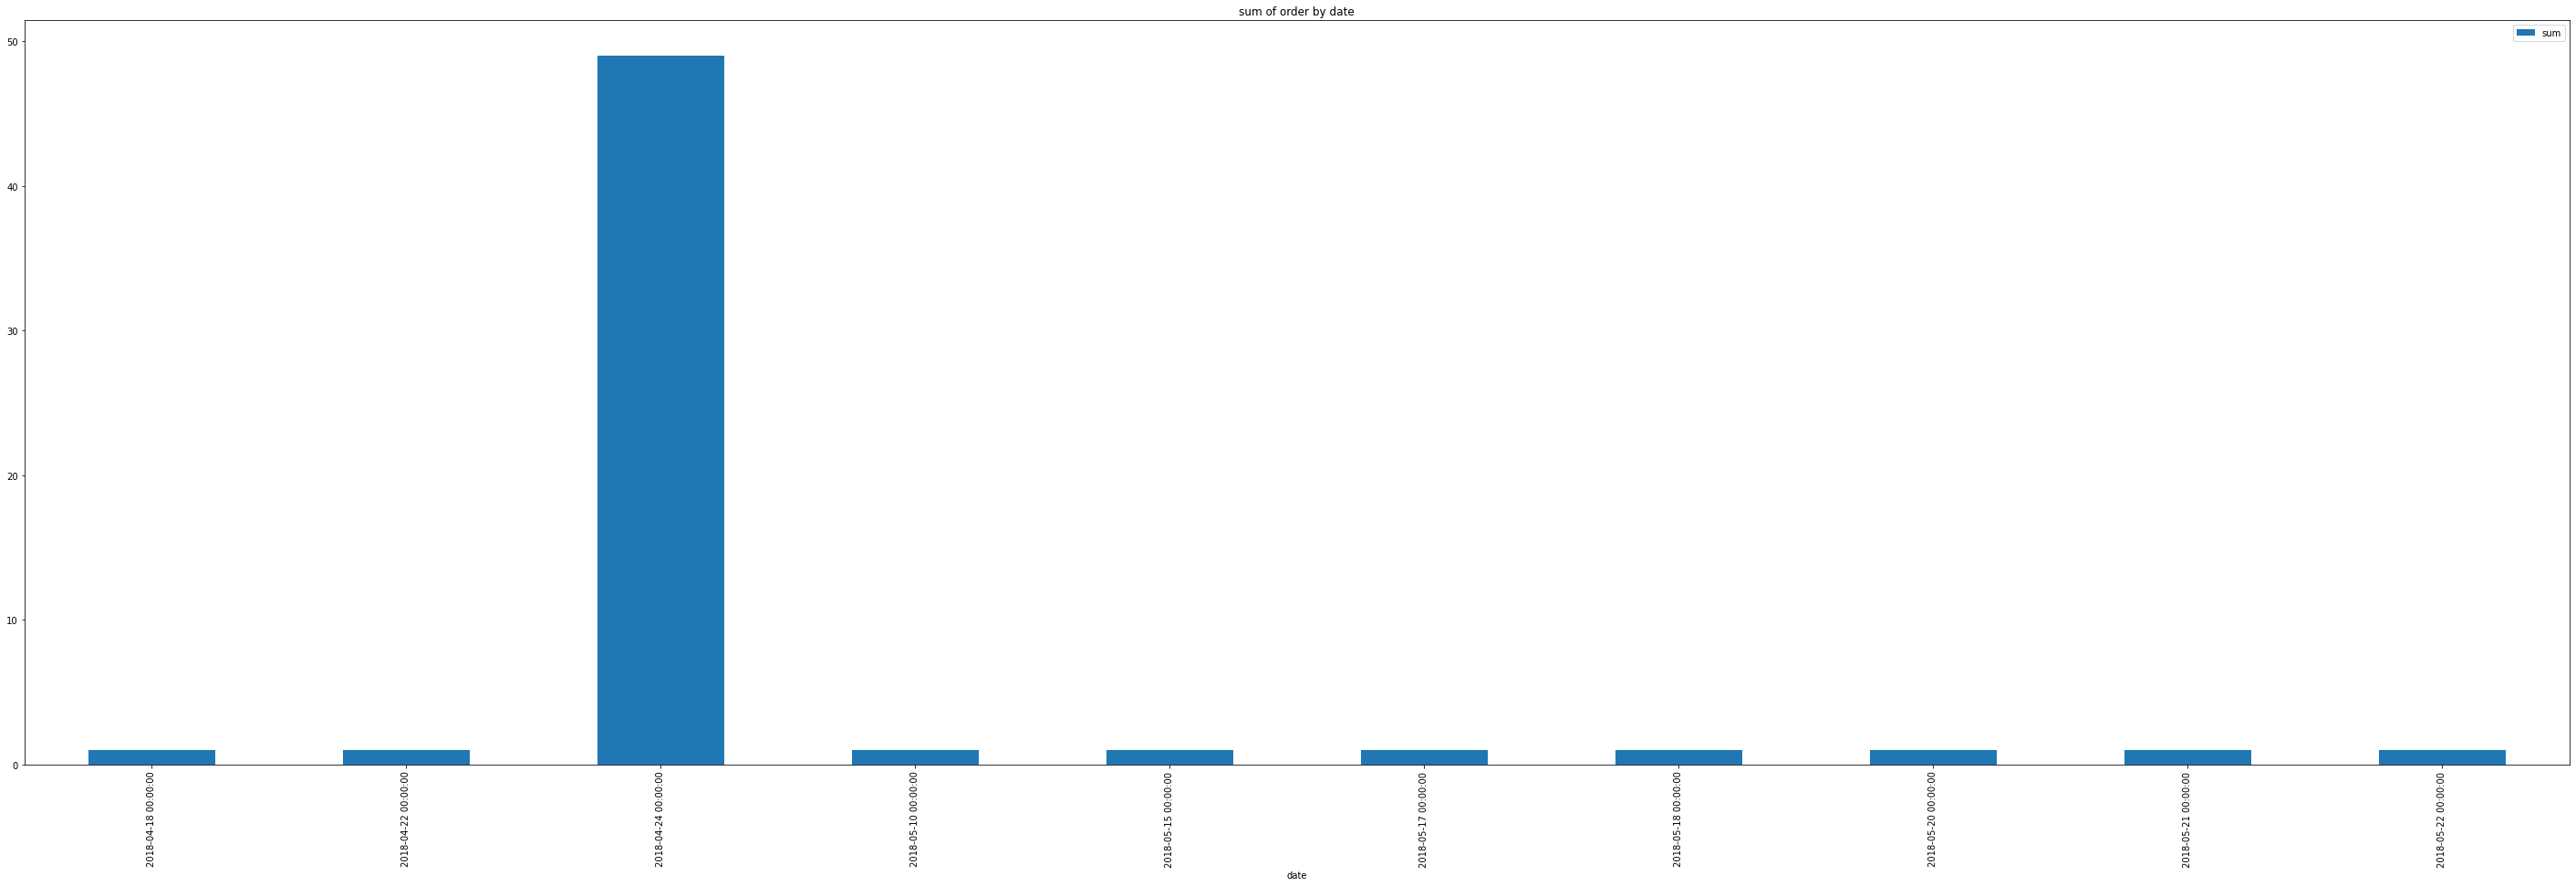

In [30]:
df_daily = train.loc[train['itemID'] == 981].groupby('date').agg(['sum']).reset_index()
df_daily.plot(x='date', y='order',kind="bar", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))

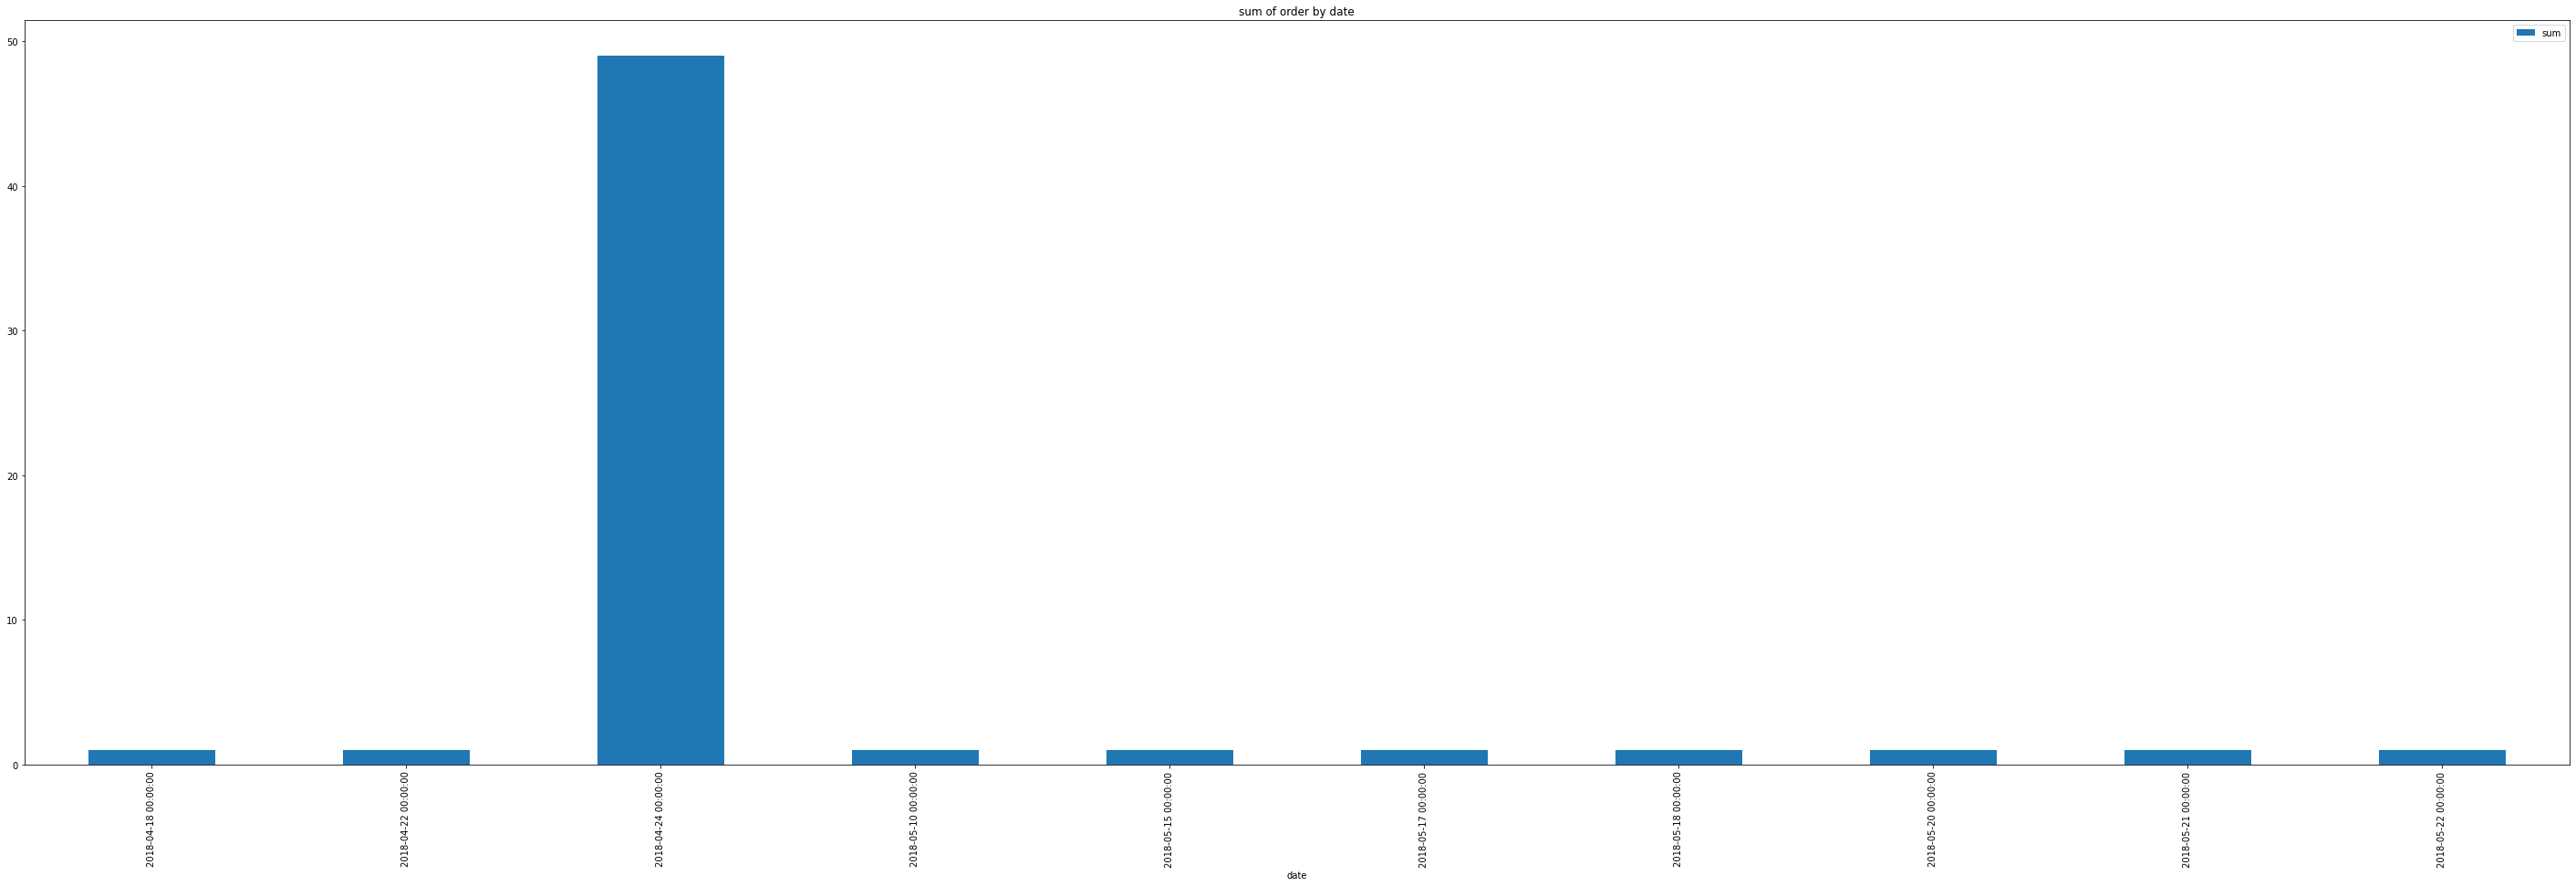

In [42]:
df_daily = train.loc[train['itemID'] == 981].groupby('date').agg(['sum']).reset_index()
df_daily.plot(x='date', y='order',kind="bar", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))

# Order ranges

In [44]:
orders['time'] = orders.apply(lambda row: datetime.datetime.strptime(row['time'],"%Y-%m-%d %H:%M:%S"), axis=1)
# Just the date, no time
orders['date'] = orders.apply(lambda row: datetime.datetime(year=2018, month=row['time'].month, day=row['time'].day), axis=1)


In [45]:
orders.head()

,time,transactID,itemID,order,salesPrice,date
0,2018-01-01 00:01:56,2278968,450,1,17.42,2018-01-01
1,2018-01-01 00:01:56,2278968,83,1,5.19,2018-01-01
2,2018-01-01 00:07:11,2255797,7851,2,20.47,2018-01-01
3,2018-01-01 00:09:24,2278968,450,1,17.42,2018-01-01
4,2018-01-01 00:09:24,2278968,83,1,5.19,2018-01-01


In [71]:
orders_ = orders.copy()

In [72]:
gb = orders_.groupby(['itemID', 'date']).agg(total_orders=pd.NamedAgg(column='order', aggfunc=sum)).reset_index()

In [74]:
gb.head()

,itemID,date,total_orders
0,1,2018-01-23,1
1,1,2018-01-25,1
2,1,2018-01-29,307
3,1,2018-01-30,3
4,1,2018-01-31,1


In [75]:
do = {itemID: list(gb.loc[gb['itemID'] == itemID]['total_orders']) for itemID in unique_itemIDs}

In [91]:
days = {itemID: list(gb.loc[gb['itemID'] == itemID]['date']) for itemID in unique_itemIDs}

In [92]:
days = {k: [str(date)[:10] for date in v] for k,v in days.items()}

In [94]:
daily_orders = pd.DataFrame({'itemID': list(do.keys()), 'list_daily_orders': list(do.values()), 'list_ordering_days': list(days.values())})


In [95]:
daily_orders.head()

,itemID,list_daily_orders,list_ordering_days
0,1,"[1, 1, 307, 3, 1, 2, 1, 1, 1, 27, 3, 2, 1, 1, ...","[2018-01-23, 2018-01-25, 2018-01-29, 2018-01-3..."
1,2,"[1, 1, 1, 2]","[2018-02-24, 2018-02-26, 2018-05-27, 2018-05-29]"
2,3,"[1, 89, 2, 1, 1, 1, 1, 90, 1, 1, 2]","[2018-01-10, 2018-01-18, 2018-01-19, 2018-01-2..."
3,4,"[1, 1, 2, 42, 1, 1, 4, 1]","[2018-01-18, 2018-02-28, 2018-04-08, 2018-04-2..."
4,5,"[1, 1, 1, 1, 124, 2, 1, 4, 39, 2, 1]","[2018-01-06, 2018-01-07, 2018-01-21, 2018-02-1..."


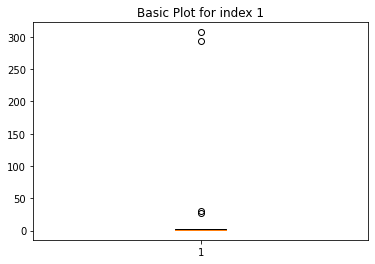

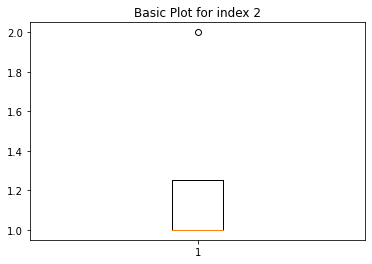

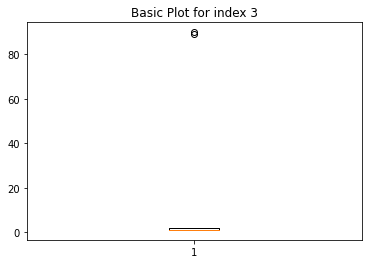

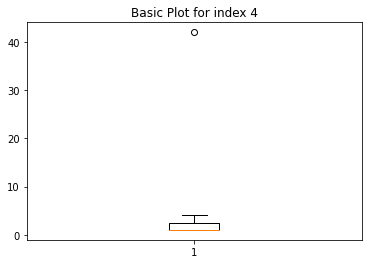

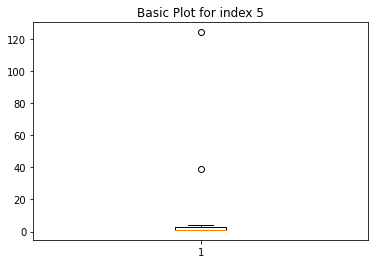

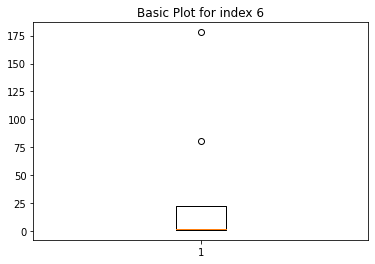

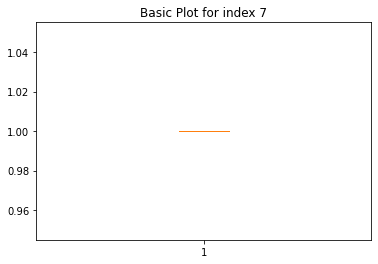

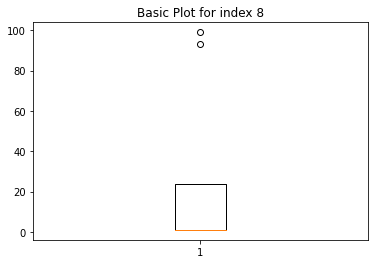

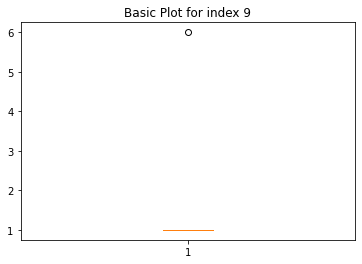

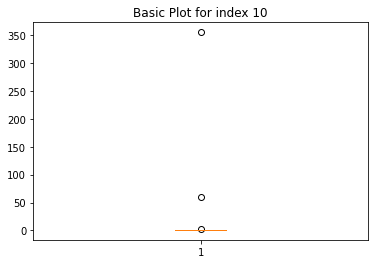

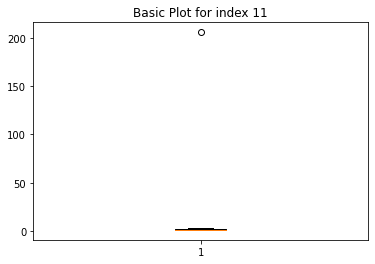

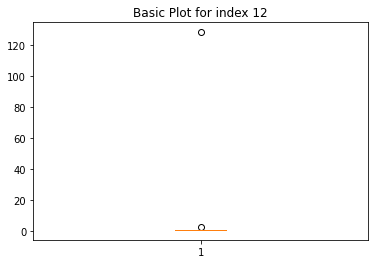

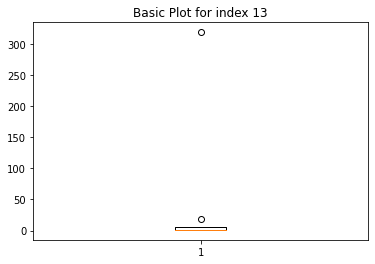

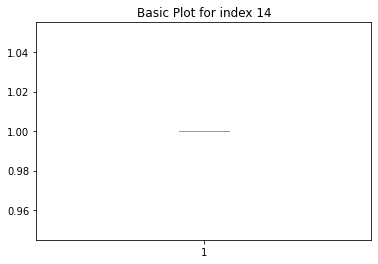

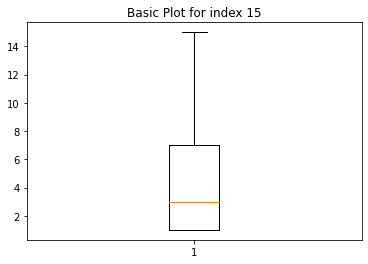

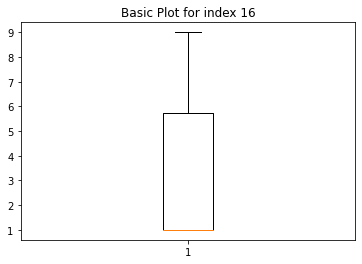

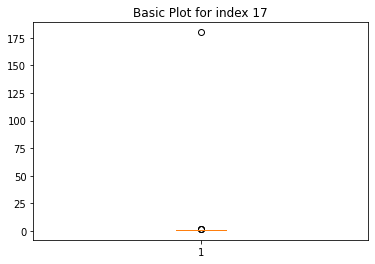

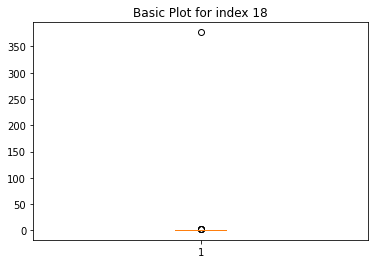

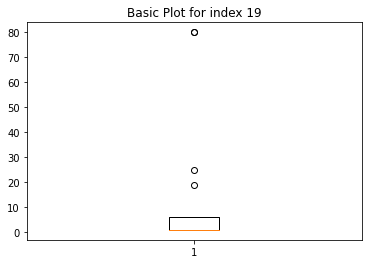

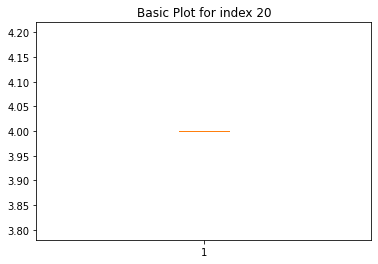

In [96]:
for i in range(20):
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot for index {}'.format(daily_orders['itemID'][i]))
    ax1.boxplot(daily_orders['list_daily_orders'][i])

In [97]:
daily_orders['median'] = daily_orders.apply(lambda row: median(row['list_daily_orders']), axis=1)

In [98]:
daily_orders['iqr'] = daily_orders.apply(lambda row: iqr(row['list_daily_orders']), axis=1)

In [99]:
daily_orders['iqr_'] = daily_orders.apply(lambda row: iqr(row['list_daily_orders'], rng=(25,90)), axis=1)
daily_orders['upper_bound_'] = daily_orders.apply(lambda row: row['median'] + 2 * row['iqr_'], axis=1)

In [100]:
daily_orders['upper_bound'] = daily_orders.apply(lambda row: row['median'] + 1.5 * row['iqr'], axis=1)

In [134]:
daily_orders.loc[daily_orders['median'] > 15]

,itemID,list_daily_orders,list_ordering_days,median,iqr,iqr_,upper_bound_,upper_bound
33,34,"[45, 27, 1, 15, 1, 23]","[2018-03-15, 2018-04-07, 2018-04-20, 2018-04-2...",19.0,21.50,31.50,82.0,51.250
48,51,"[184, 1]","[2018-02-19, 2018-04-25]",92.5,91.50,118.95,330.4,229.750
95,100,"[93, 1, 2, 71]","[2018-03-23, 2018-03-26, 2018-03-29, 2018-05-01]",36.5,74.75,84.65,205.8,148.625
99,104,"[1, 170]","[2018-02-19, 2018-05-16]",85.5,84.50,109.85,305.2,212.250
105,111,[20],[2018-03-04],20.0,0.00,0.00,20.0,20.000
106,112,"[2, 296, 1, 2, 3, 102, 80, 95]","[2018-01-18, 2018-02-10, 2018-03-04, 2018-04-0...",41.5,94.75,158.20,357.9,183.625
149,157,"[47, 56, 2, 18]","[2018-01-24, 2018-03-21, 2018-03-22, 2018-05-27]",32.5,35.25,39.30,111.1,85.375
154,162,"[35, 1]","[2018-02-19, 2018-02-23]",18.0,17.00,22.10,62.2,43.500
168,176,"[1, 86, 103]","[2018-02-08, 2018-04-17, 2018-05-01]",86.0,51.00,56.10,198.2,162.500
180,188,"[1, 36, 2, 39, 1, 79]","[2018-02-21, 2018-04-05, 2018-04-06, 2018-04-1...",19.0,37.00,57.75,134.5,74.500


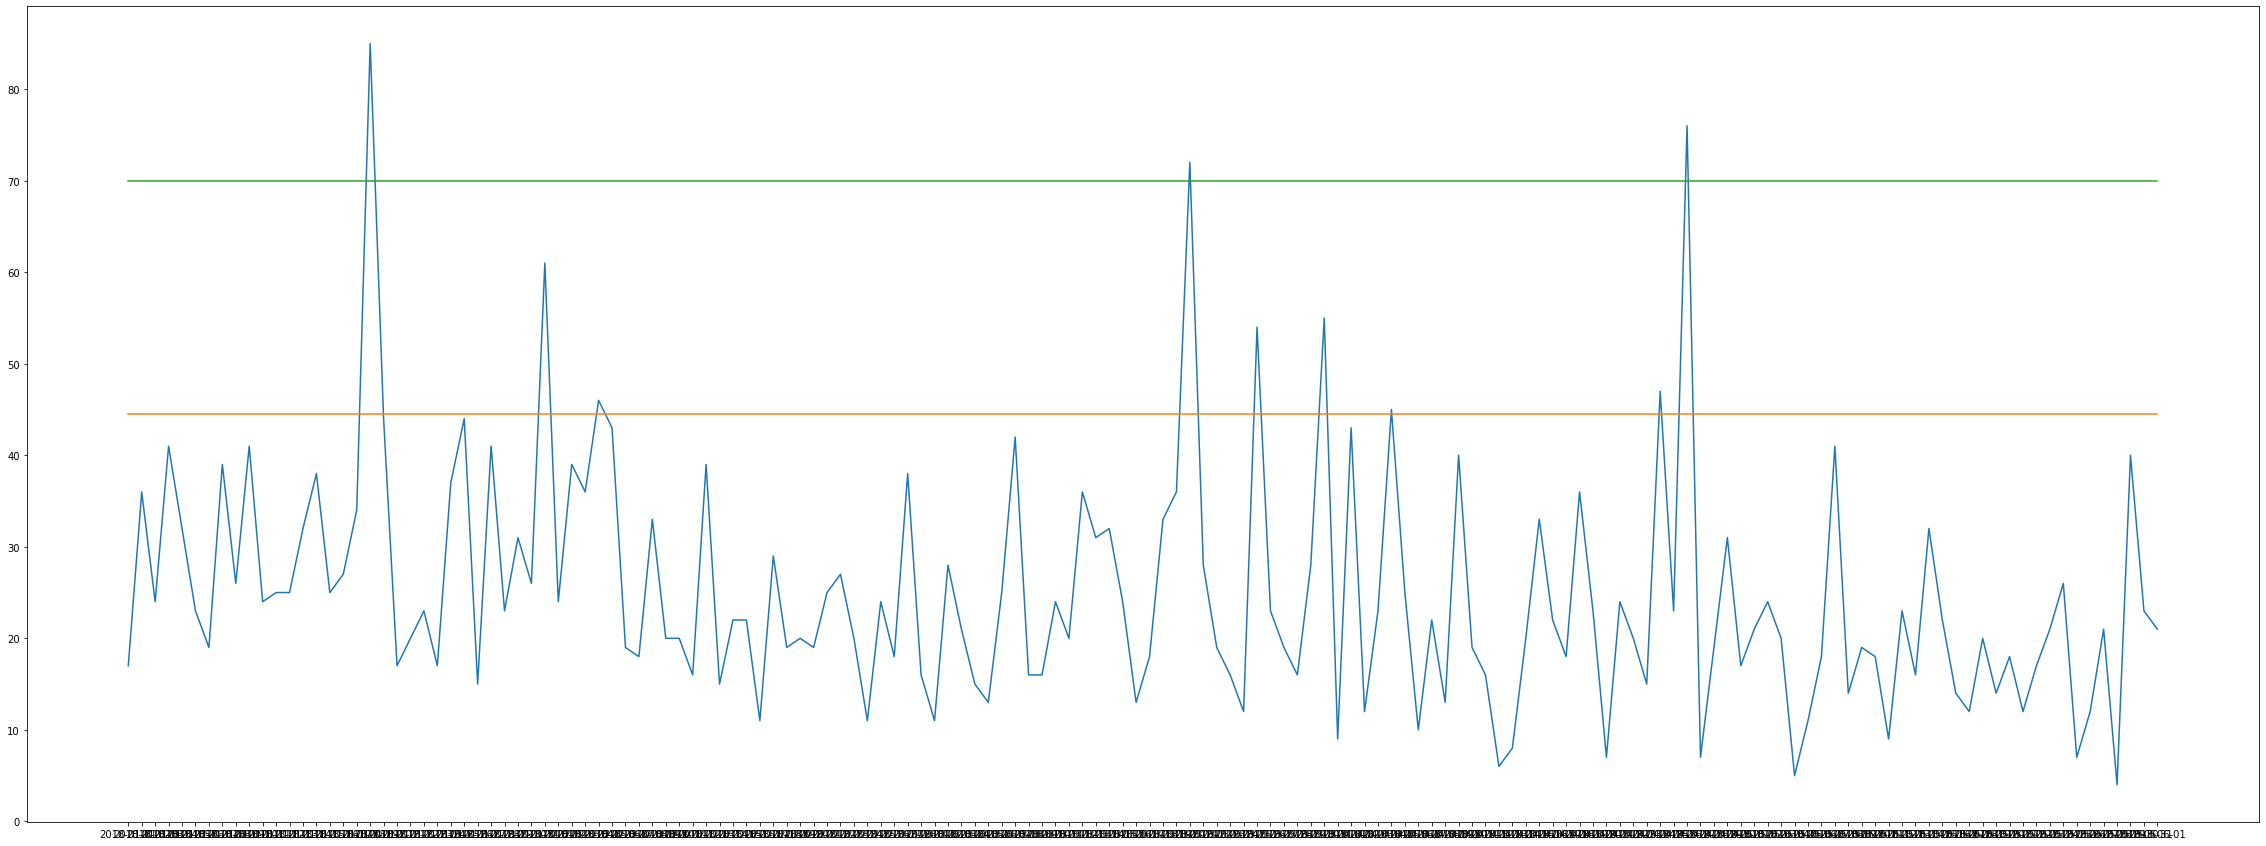

In [116]:
df = daily_orders.loc[daily_orders['itemID'] == 7798].reset_index()
plt.figure(figsize=(40,15)) 
plt.plot(df['list_ordering_days'][0], df['list_daily_orders'][0])
plt.plot(df['list_ordering_days'][0], [df['upper_bound'][0]] * len(df['list_ordering_days'][0]))
plt.plot(df['list_ordering_days'][0], [df['upper_bound_'][0]] * len(df['list_ordering_days'][0]))
plt.show()

[Text(0.5, 3.200000000000017, '')]

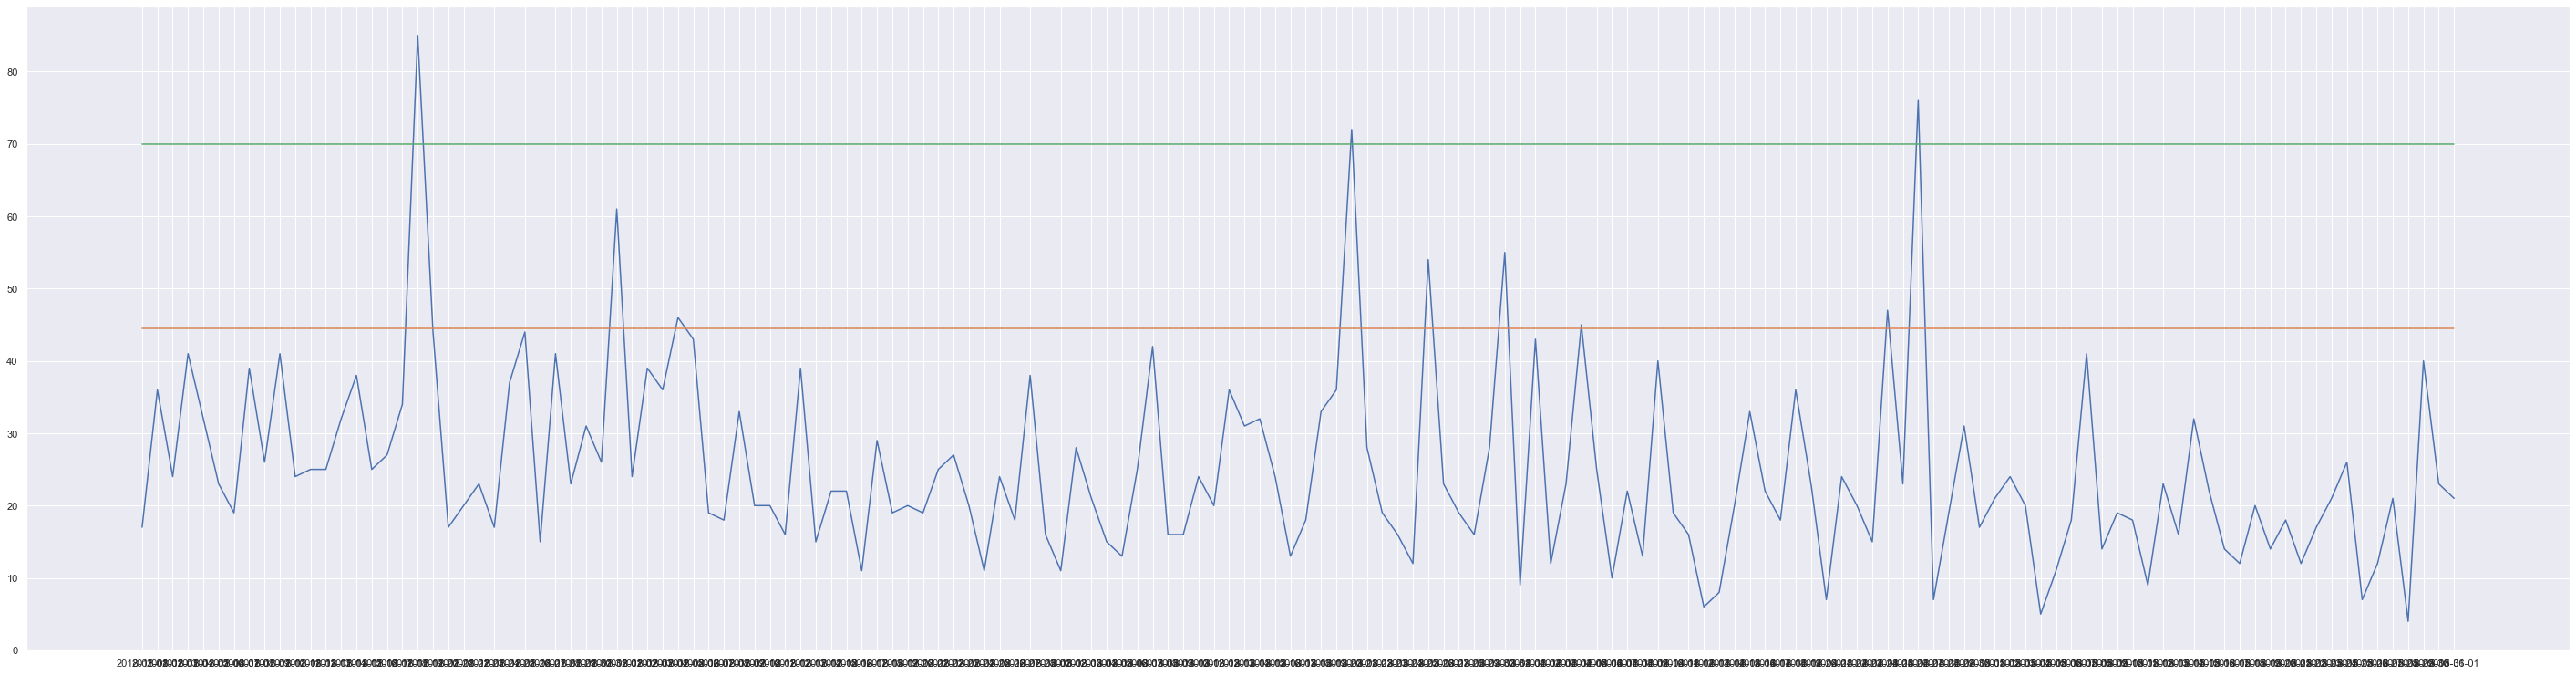

In [122]:
df = daily_orders.loc[daily_orders['itemID'] == 7798].reset_index()
sns.set(rc={'figure.figsize':(50,13)})
sns.lineplot(df['list_ordering_days'][0], df['list_daily_orders'][0])
sns.lineplot(df['list_ordering_days'][0], [df['upper_bound'][0]] * len(df['list_ordering_days'][0]))
sns.lineplot(df['list_ordering_days'][0], [df['upper_bound_'][0]] * len(df['list_ordering_days'][0]))
ax.set(xlabel=None)

[Text(0.5, 0, '')]

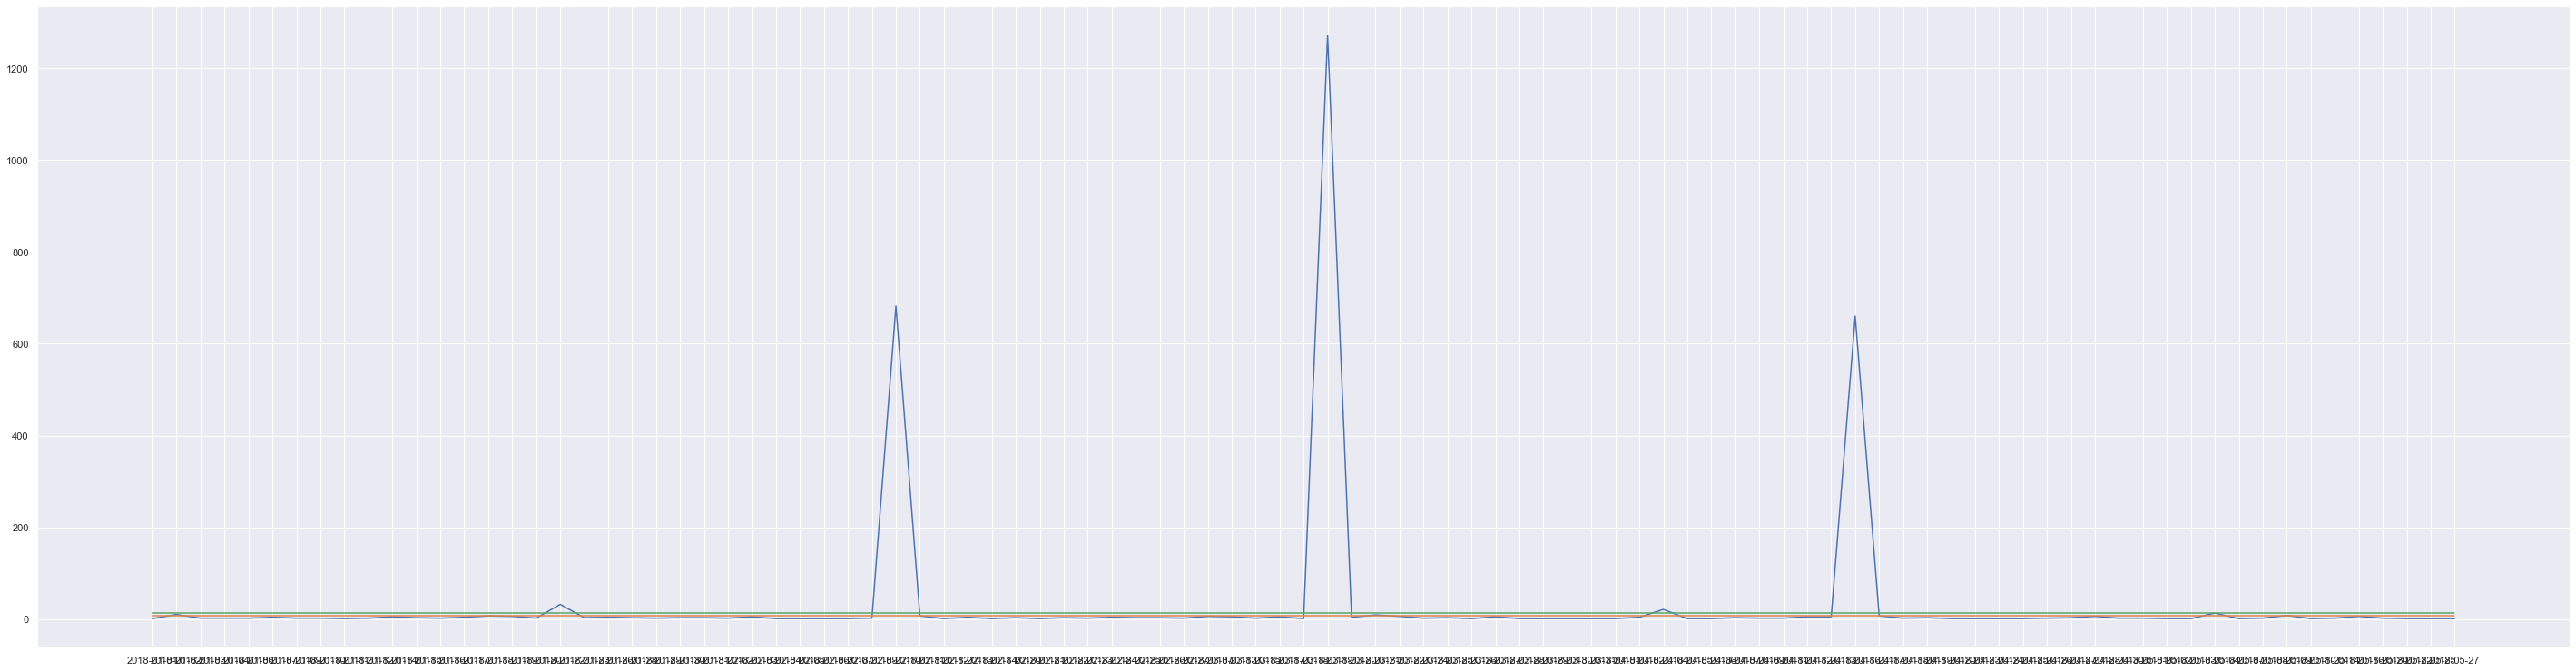

In [121]:
df = daily_orders.loc[daily_orders['itemID'] == 7761].reset_index()
sns.set(rc={'figure.figsize':(50,13)})
ax = sns.lineplot(df['list_ordering_days'][0], df['list_daily_orders'][0])
ax = sns.lineplot(df['list_ordering_days'][0], [df['upper_bound'][0]] * len(df['list_ordering_days'][0]))
ax = sns.lineplot(df['list_ordering_days'][0], [df['upper_bound_'][0]] * len(df['list_ordering_days'][0]))
ax.set(xlabel=None)

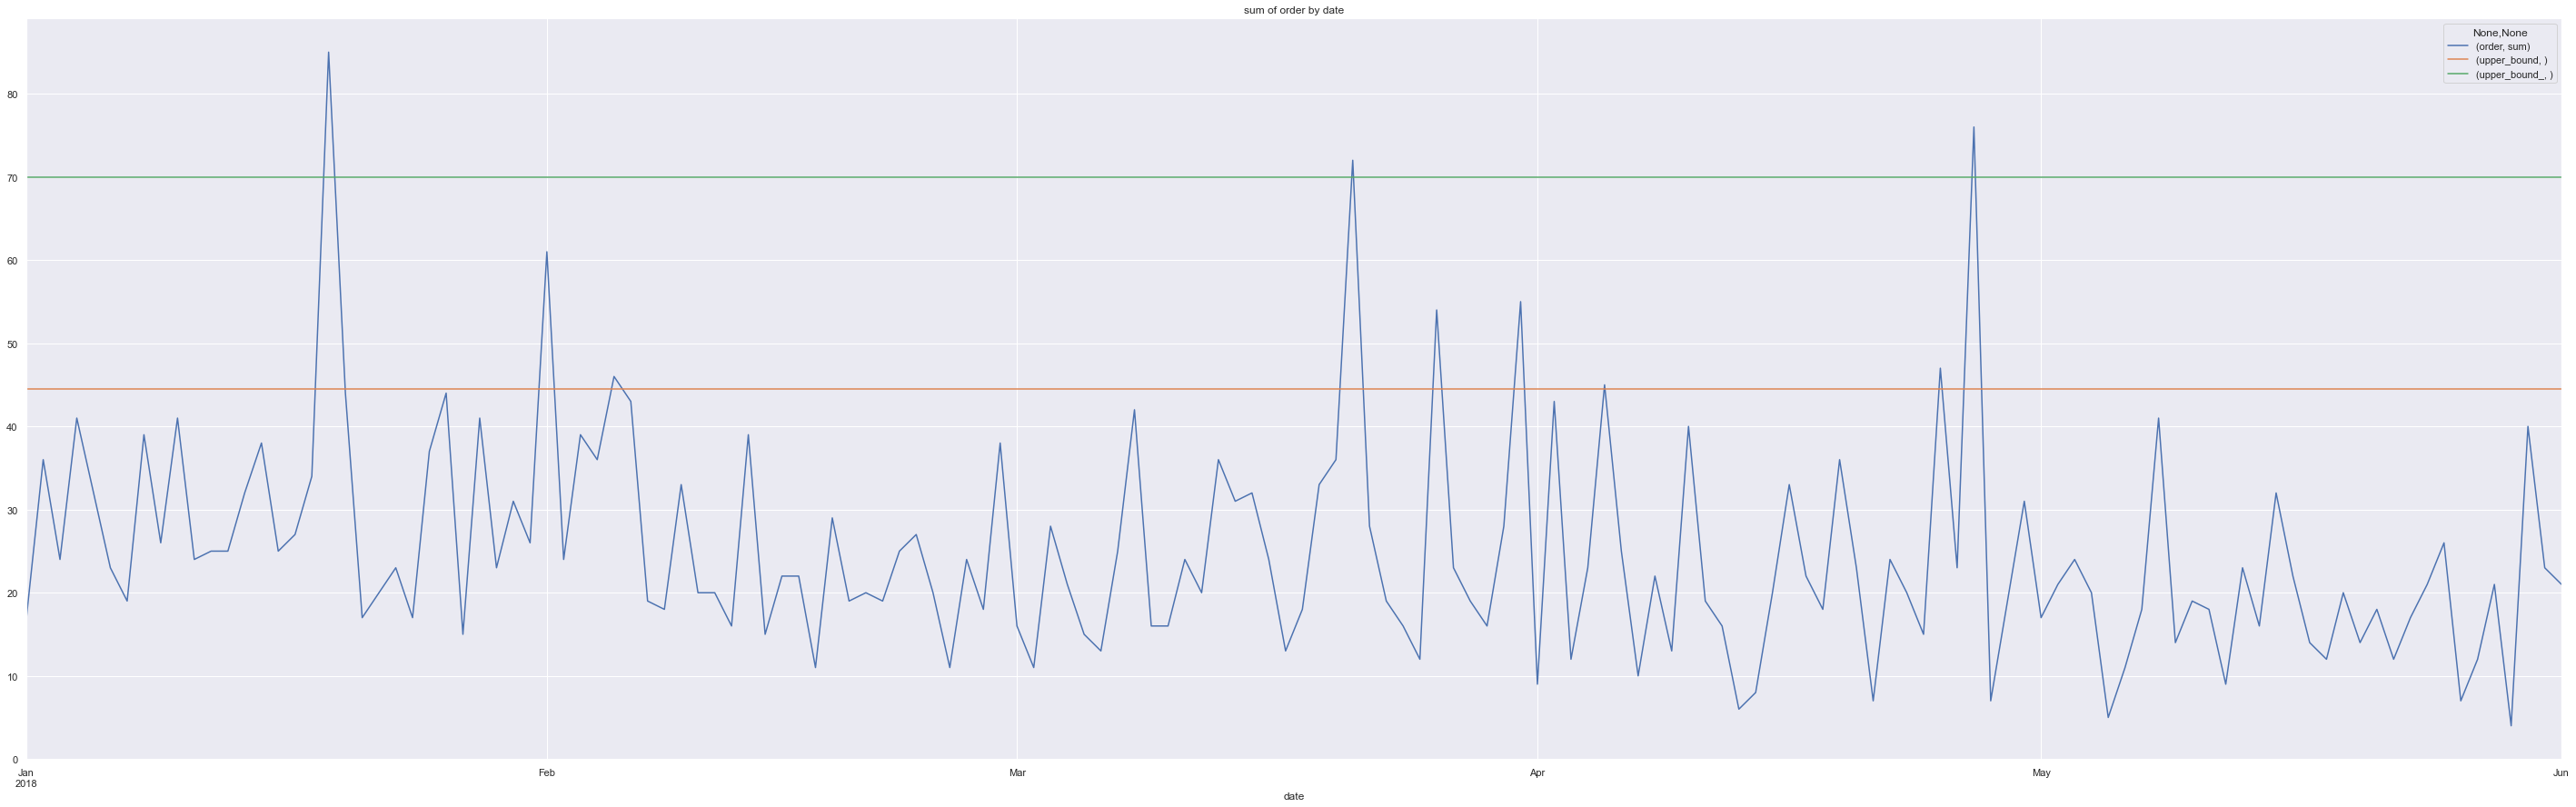

In [140]:
df_daily = train.loc[train['itemID'] == 7798].groupby('date').agg(['sum']).reset_index()
df_daily['upper_bound'] = daily_orders.loc[daily_orders['itemID'] == 7798].reset_index()['upper_bound'][0]
df_daily['upper_bound_'] = daily_orders.loc[daily_orders['itemID'] == 7798].reset_index()['upper_bound_'][0]
df_daily.plot(x='date', y=['order', 'upper_bound', 'upper_bound_'],kind="line", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))

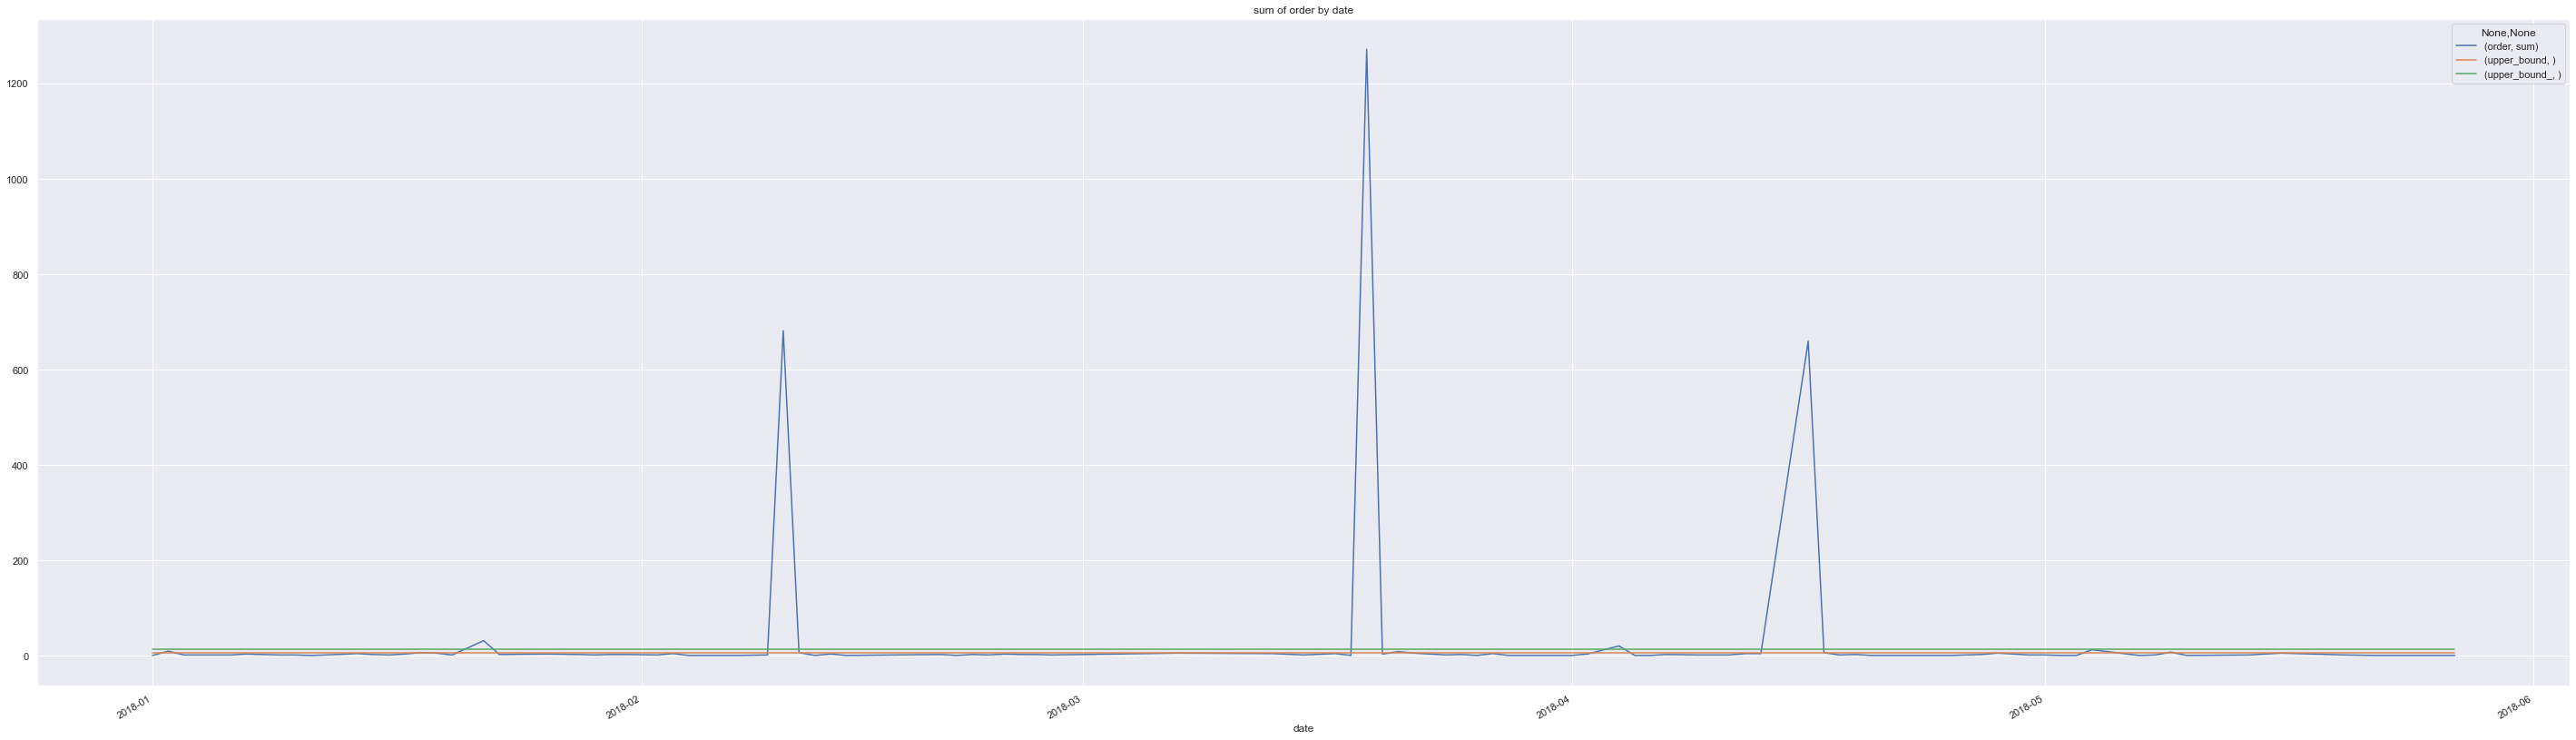

In [141]:
df_daily = train.loc[train['itemID'] == 7761].groupby('date').agg(['sum']).reset_index()
df_daily['upper_bound'] = daily_orders.loc[daily_orders['itemID'] == 7761].reset_index()['upper_bound'][0]
df_daily['upper_bound_'] = daily_orders.loc[daily_orders['itemID'] == 7761].reset_index()['upper_bound_'][0]
df_daily.plot(x='date', y=['order', 'upper_bound', 'upper_bound_'],kind="line", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))

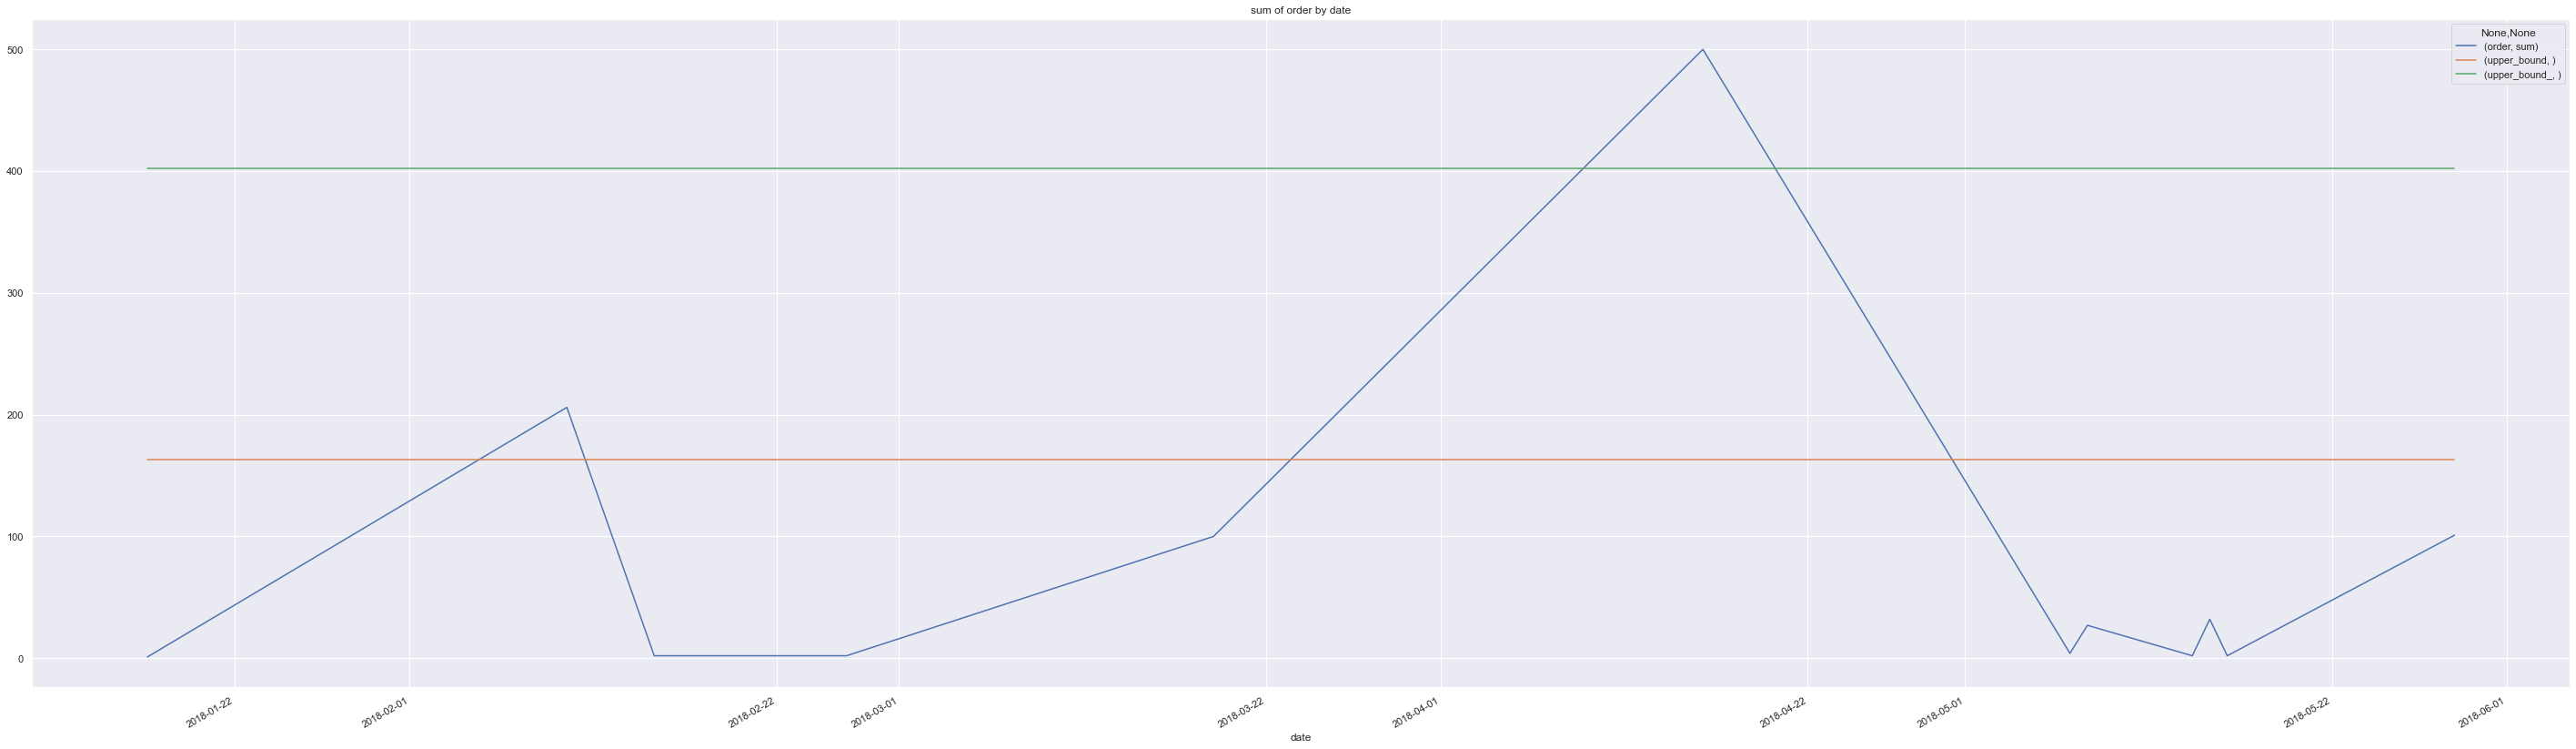

In [142]:
df_daily = train.loc[train['itemID'] == 7816].groupby('date').agg(['sum']).reset_index()
df_daily['upper_bound'] = daily_orders.loc[daily_orders['itemID'] == 7816].reset_index()['upper_bound'][0]
df_daily['upper_bound_'] = daily_orders.loc[daily_orders['itemID'] == 7816].reset_index()['upper_bound_'][0]
df_daily.plot(x='date', y=['order', 'upper_bound', 'upper_bound_'],kind="line", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))

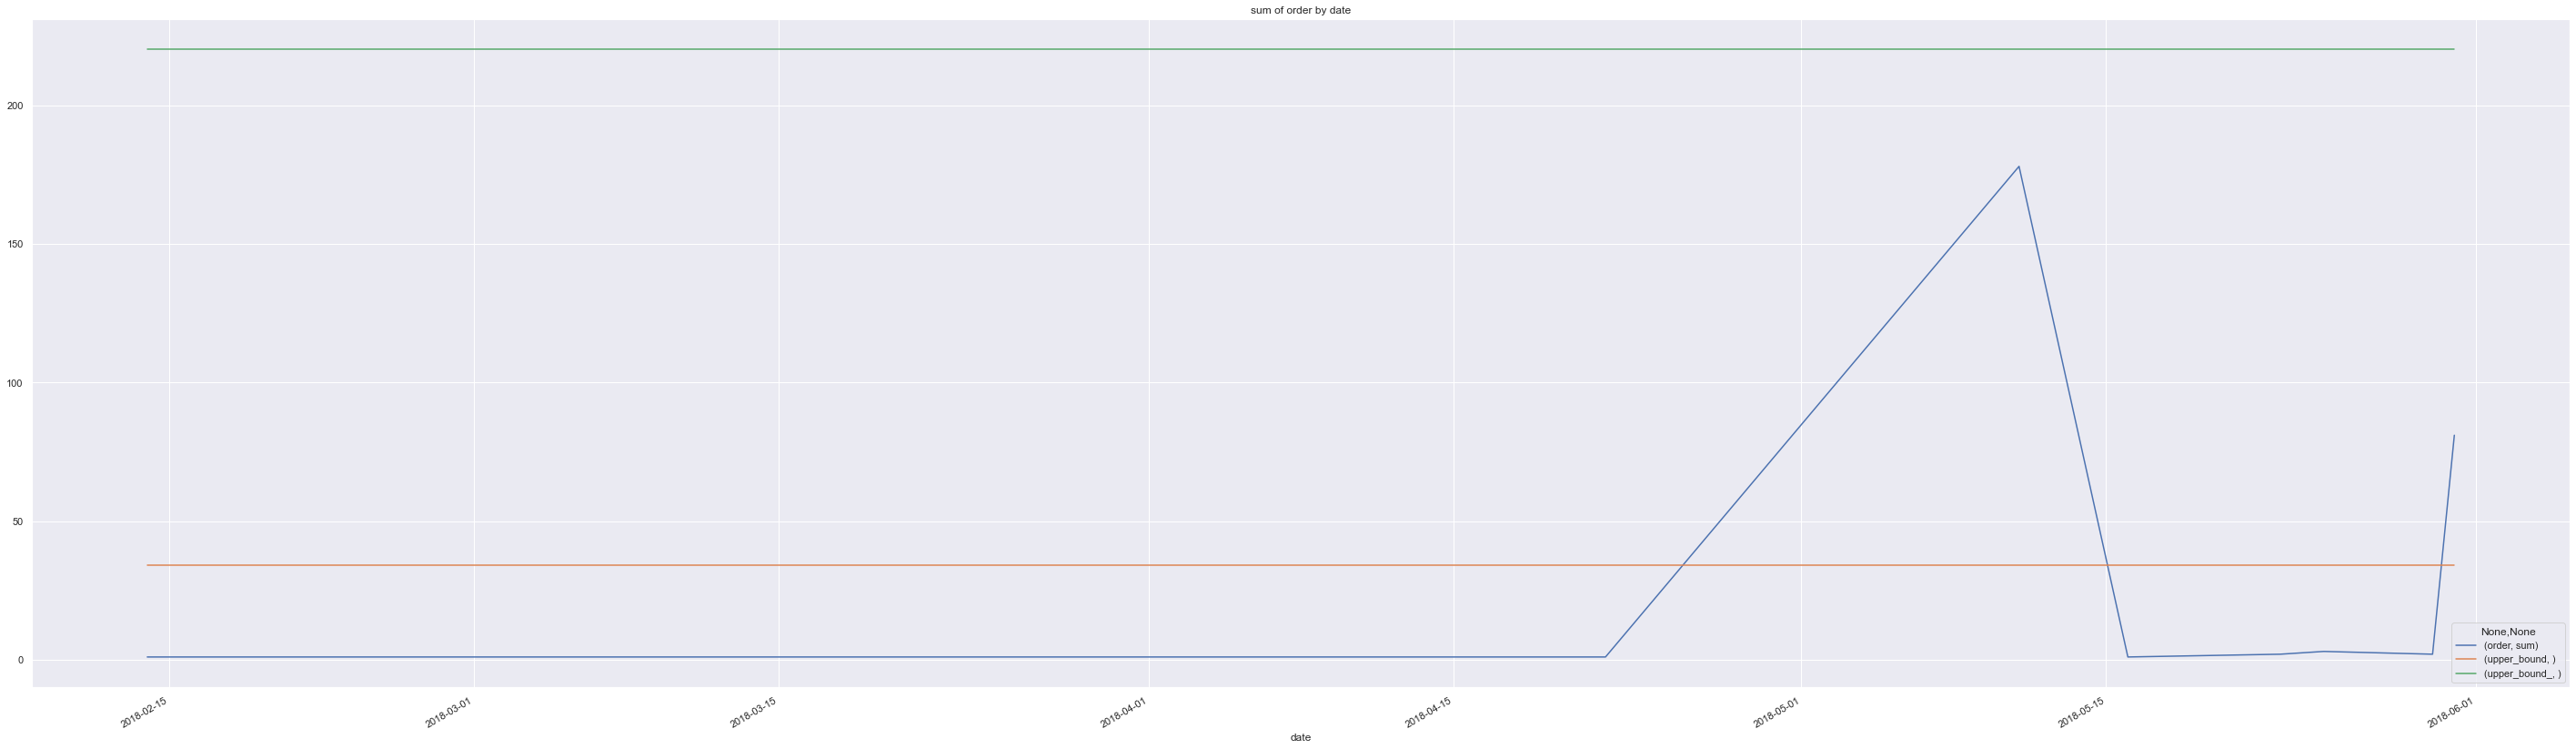

In [143]:
df_daily = train.loc[train['itemID'] == 6].groupby('date').agg(['sum']).reset_index()
df_daily['upper_bound'] = daily_orders.loc[daily_orders['itemID'] == 6].reset_index()['upper_bound'][0]
df_daily['upper_bound_'] = daily_orders.loc[daily_orders['itemID'] == 6].reset_index()['upper_bound_'][0]
df_daily.plot(x='date', y=['order', 'upper_bound', 'upper_bound_'],kind="line", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,15))